In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas
!pip install pysheds
!pip install mplleaflet
!pip install IPython
!pip install simplekml

     |████████████████████████████████| 972kB 8.5MB/s 
     |████████████████████████████████| 14.8MB 207kB/s 
     |████████████████████████████████| 6.5MB 39.6MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 19.1MB 1.3MB/s 
  Created wheel for pysheds: filename=pysheds-0.2.7-cp36-none-any.whl size=51838 sha256=230f5b5abacfc4a2ab6b9b33f5a054f0ad4fc54573ee866f03bbc3eb44543a48
  Stored in directory: /root/.cache/pip/wheels/e4/87/6f/f67cbfbc39ea2c76e0cb801c37590b9e3c47e9eee7baea2547
Successfully built pysheds
  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-cp36-none-any.whl size=28555 sha256=cf1e3cc5799828ed5ea0eb16722f985bf92d328475b4fc84e6f7c4b1e3fd44aa
  Stored in directory: /root/.cache/pip/wheels/bf/fd/0b/0513de62c339c4a56e2234aa42a5d06e6660a4446fdae7b796
Successfully built mplleaflet
     |████████████████████████████████| 71kB 4.8MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
from pyproj import CRS
%matplotlib inline
from IPython.display import IFrame
import gdal


In [4]:
!gdalwarp -t_srs EPSG:4326 /content/drive/MyDrive/DEM/m_idukki1.tif output.tif


Creating output file that is 2835P x 3897L.
Processing input file /content/drive/MyDrive/DEM/m_idukki1.tif.
Using internal nodata values (e.g. 0) for image /content/drive/MyDrive/DEM/m_idukki1.tif.
Copying nodata values from source /content/drive/MyDrive/DEM/m_idukki1.tif to destination output.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [5]:
grid = Grid.from_raster('/content/output.tif', data_name='dem')

In [6]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    # plt.imshow(data, cmap=cmap)

    plt.colorbar(label=label)
    plt.grid()

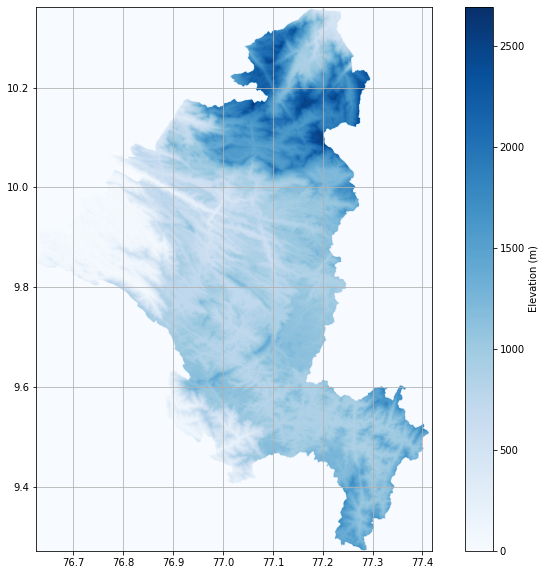

In [7]:
plotFigure(grid.dem, 'Elevation (m)')

In [8]:
depressions = grid.detect_depressions('dem')


Text(0.5, 1.0, 'Depressions')

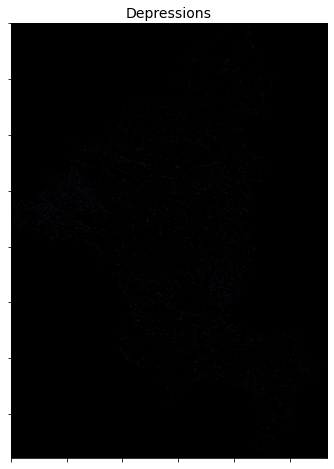

In [9]:

# Plot pits
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(depressions, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Depressions', size=14)

In [10]:
grid.fill_depressions(data='dem', out_name='flooded_dem')


In [11]:
flats = grid.detect_flats('flooded_dem')


Text(0.5, 1.0, 'Flats')

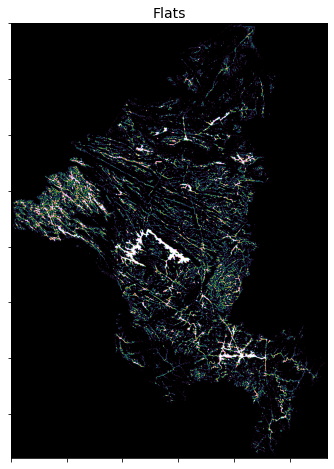

In [12]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [13]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')


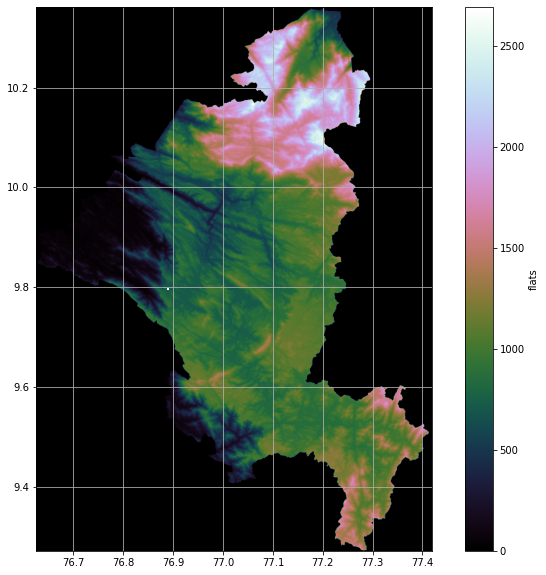

In [14]:
plotFigure(grid.inflated_dem, 'flats', 'cubehelix')

In [15]:
flats_test = grid.detect_flats('inflated_dem')


Text(0.5, 1.0, 'Flats')

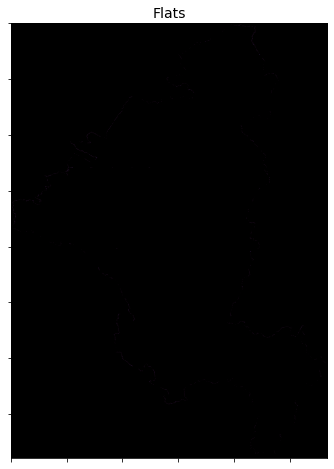

In [16]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(flats_test, cmap='cubehelix', zorder=1)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title('Flats', size=14)

In [18]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [ ]:
new_crs = CRS('epsg:4326')

In [19]:
# Compute flow direction based on corrected DEM
# grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap , as_crs=new_crs)
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)


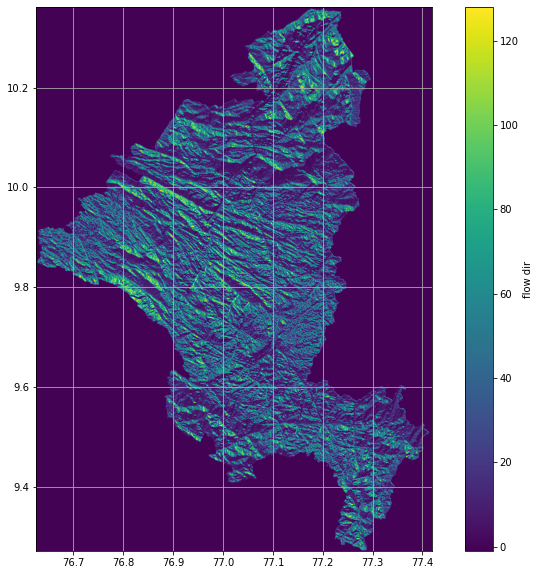

In [20]:
plotFigure(grid.dir , 'flow dir', 'viridis')

In [21]:
# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

In [ ]:
# import pyproj

# # Compute areas of each cell in new projection
# new_crs = pyproj.Proj('+init=epsg:3083')
# areas = grid.cell_area(as_crs=new_crs, inplace=False)

# # Weight each cell by its relative area
# weights = (areas / areas.max()).ravel()

# # Compute accumulation with new weights
# grid.accumulation(data='dir', weights=weights, out_name='acc')

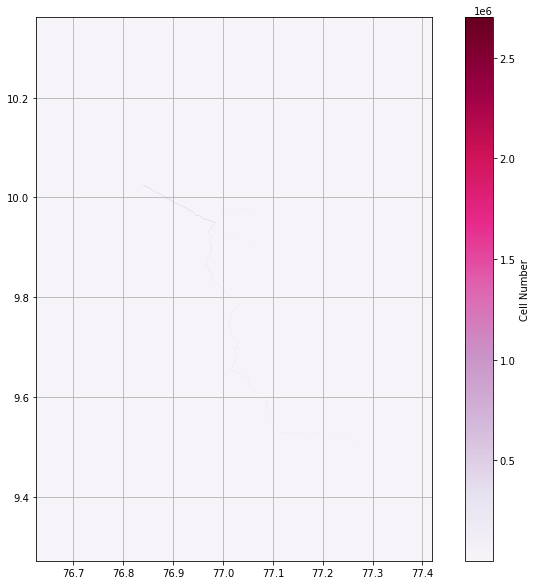

In [22]:
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

In [23]:
# Delineate catchment at point of high accumulation
y, x = np.unravel_index(np.argsort(grid.acc.ravel())[-2], grid.acc.shape)
grid.catchment(x, y, data='dir', out_name='catch',
               dirmap=dirmap, xytype='index')


In [24]:
streams = grid.extract_river_network('catch', 'acc', threshold=5000, dirmap=dirmap)
streams["features"][:2]

[{"geometry": {"coordinates": [[77.202228, 10.144935], [77.202228, 10.145215], [77.202228, 10.145495], [77.202508, 10.145774], [77.202788, 10.146054], [77.203067, 10.146334], [77.203067, 10.146614], [77.203067, 10.146893], [77.203347, 10.147173], [77.203627, 10.147453], [77.203906, 10.147732], [77.203906, 10.148012], [77.203906, 10.148292], [77.203906, 10.148572], [77.203906, 10.148851], [77.204186, 10.149131], [77.204466, 10.149411], [77.204746, 10.14969], [77.205025, 10.14997], [77.205305, 10.15025], [77.205305, 10.15053], [77.205305, 10.150809], [77.205585, 10.151089], [77.205864, 10.151369], [77.206144, 10.151648], [77.206144, 10.151928], [77.206424, 10.152208], [77.206703, 10.152487], [77.206983, 10.152487], [77.206983, 10.152767], [77.207263, 10.153047], [77.207543, 10.153327], [77.207822, 10.153606], [77.208102, 10.153606], [77.208382, 10.153606], [77.208661, 10.153886], [77.208941, 10.154166], [77.209221, 10.154445], [77.209501, 10.154725], [77.20978, 10.155005], [77.20978, 10.

In [29]:
print(streams)

{"features": [{"geometry": {"coordinates": [[77.202228, 10.144935], [77.202228, 10.145215], [77.202228, 10.145495], [77.202508, 10.145774], [77.202788, 10.146054], [77.203067, 10.146334], [77.203067, 10.146614], [77.203067, 10.146893], [77.203347, 10.147173], [77.203627, 10.147453], [77.203906, 10.147732], [77.203906, 10.148012], [77.203906, 10.148292], [77.203906, 10.148572], [77.203906, 10.148851], [77.204186, 10.149131], [77.204466, 10.149411], [77.204746, 10.14969], [77.205025, 10.14997], [77.205305, 10.15025], [77.205305, 10.15053], [77.205305, 10.150809], [77.205585, 10.151089], [77.205864, 10.151369], [77.206144, 10.151648], [77.206144, 10.151928], [77.206424, 10.152208], [77.206703, 10.152487], [77.206983, 10.152487], [77.206983, 10.152767], [77.207263, 10.153047], [77.207543, 10.153327], [77.207822, 10.153606], [77.208102, 10.153606], [77.208382, 10.153606], [77.208661, 10.153886], [77.208941, 10.154166], [77.209221, 10.154445], [77.209501, 10.154725], [77.20978, 10.155005], [

In [30]:
for new in streams['features']:
  line = np.asarray(new['geometry']['coordinates'])
  print(line)

Streaming output truncated to the last 5000 lines.
 [77.279707  9.52874 ]
 [77.279987  9.52846 ]
 [77.280267  9.52846 ]
 [77.280546  9.528181]
 [77.280826  9.527901]
 [77.281106  9.527901]
 [77.281385  9.527621]
 [77.281385  9.527342]
 [77.281106  9.527062]
 [77.280826  9.526782]
 [77.280546  9.526502]
 [77.280267  9.526223]
 [77.280267  9.525943]
 [77.280267  9.525663]
 [77.280267  9.525384]
 [77.280546  9.525104]
 [77.280546  9.524824]
 [77.280826  9.524544]
 [77.281106  9.524265]
 [77.281385  9.523985]
 [77.281665  9.523705]
 [77.281945  9.523426]
 [77.282224  9.523146]
 [77.282504  9.523146]
 [77.282784  9.523146]
 [77.283064  9.523146]
 [77.283343  9.523426]
 [77.283623  9.523705]
 [77.283903  9.523705]
 [77.284182  9.523985]
 [77.284462  9.523985]
 [77.284742  9.524265]
 [77.285022  9.524544]
 [77.285022  9.524824]
 [77.285022  9.525104]
 [77.285022  9.525384]
 [77.285022  9.525663]
 [77.285022  9.525943]
 [77.285022  9.526223]
 [77.285022  9.526502]
 [77.285022  9.526782]
 [77.2

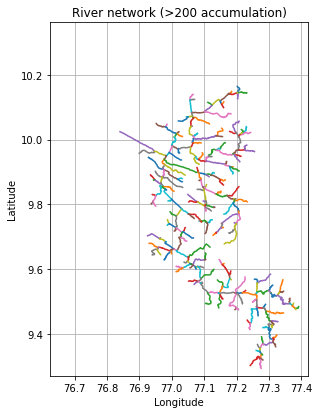

In [25]:
fig, ax = plt.subplots(figsize=(6.5,6.5))

plt.grid('on', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network (>200 accumulation)')
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for stream in streams['features']:
    line = np.asarray(stream['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

In [26]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [27]:
#save geojson as separate file
saveDict(streams,'streams.geojson')

In [28]:
streamNet = gpd.read_file('streams.geojson')
# streamNet.crs = {'init' :'epsg:32613'}
streamNet.crs = CRS('epsg:32613')

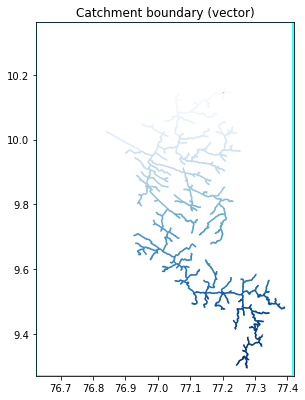

In [ ]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

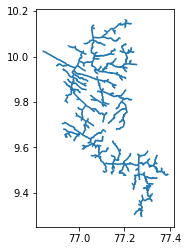

In [ ]:
ax = streamNet.plot()


In [ ]:
mplleaflet.display(fig=ax.figure , epsg=4326)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

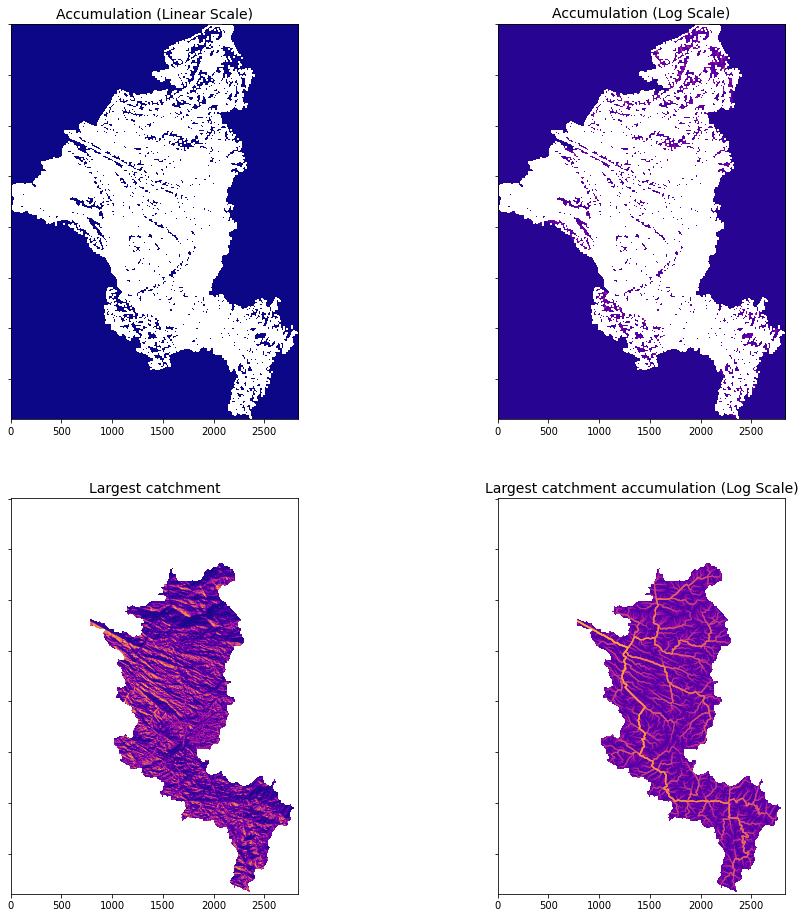

In [ ]:
# Plot accumulation and catchment
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
ax[0,0].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma')
ax[0,1].imshow(np.where(~flats, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))
ax[1,0].imshow(np.where(grid.catch, grid.catch, np.nan), zorder=1, cmap='plasma')
ax[1,1].imshow(np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',
               norm=colors.LogNorm(vmin=1, vmax=grid.acc.max()))

ax[0,0].set_title('Accumulation (Linear Scale)', size=14)
ax[0,1].set_title('Accumulation (Log Scale)', size=14)
ax[1,0].set_title('Largest catchment', size=14)
ax[1,1].set_title('Largest catchment accumulation (Log Scale)', size=14)

for i in range(ax.size):
    ax.flat[i].set_yticklabels([])

In [ ]:
streams_new = grid.extract_river_network(grid.catch, grid.view('acc') + 1, threshold=5000, dirmap=dirmap)
streams_new["features"][:2]

[{"geometry": {"coordinates": [[741313.346202, 1122255.224559], [741313.346202, 1122286.082949], [741313.346202, 1122316.941339], [741344.204592, 1122347.799729], [741375.062982, 1122378.658118], [741405.921372, 1122409.516508], [741405.921372, 1122440.374898], [741405.921372, 1122471.233288], [741436.779762, 1122502.091678], [741467.638151, 1122532.950068], [741498.496541, 1122563.808458], [741498.496541, 1122594.666847], [741498.496541, 1122625.525237], [741498.496541, 1122656.383627], [741498.496541, 1122687.242017], [741529.354931, 1122718.100407], [741560.213321, 1122748.958797], [741591.071711, 1122779.817186], [741621.930101, 1122810.675576], [741621.930101, 1122841.533966], [741621.930101, 1122872.392356], [741621.930101, 1122903.250746], [741652.78849, 1122934.109136], [741683.64688, 1122964.967525], [741714.50527, 1122995.825915], [741714.50527, 1123026.684305], [741745.36366, 1123057.542695], [741776.22205, 1123088.401085], [741807.08044, 1123088.401085], [741807.08044, 1123

In [ ]:
new = np.where(grid.catch, grid.view('acc') + 1, np.nan), zorder=1, cmap='plasma',norm=colors.LogNorm(vmin=1, vmax=grid.acc.max())

SyntaxError: ignored

In [ ]:
streams_new = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
streams["features"][:2]

In [ ]:
farmer = gpd.read_file('/content/pyshp-demo.json')
# streamNet.crs = {'init' :'epsg:32613'}
farmer.crs = CRS('epsg:4326')

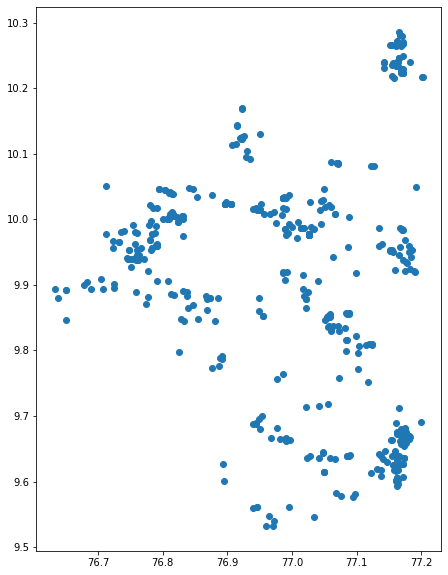

In [ ]:
ax = farmer.plot(figsize =(10,10))


In [ ]:
mplleaflet.display(fig=ax.figure, epsg=4326)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

In [ ]:
import pandas as pd
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from functools import partial

WGS84 = pyproj.Proj('epsg:4326')

def latlonbuffer(lat, lon, radius_m):
    proj4str = '+proj=aeqd +lat_0=%s +lon_0=%s +x_0=0 +y_0=0' % (lat, lon)
    AEQD = pyproj.Proj(proj4str) # azimuthal equidistant
    project = partial(pyproj.transform, AEQD, WGS84)
    return transform(project, Point(0, 0).buffer(radius_m))

In [ ]:
geometry, centroid
POLYGON((26.48306 50.09625, 26.47916 50.09604..), ((26.48307336330026, 50.052005610561245))

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=[37, 0],
           zoom_start=2.5,
           tiles='https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}',
           attr='My Data Attribution')


# geojson = r"E:\pythonProject\gz_2010_us_040_00_500k\gz_2010_us_040_00_500k\gz_2010_us_040_00_500k.geojson"

# g = folium.GeoJson(
#     geojson,
#     name='geojson'
# ).add_to(m)

# folium.GeoJsonTooltip(fields=["NAME"]).add_to(g)


m.save("index.html")